## Community State Type Analysis - Species Level
This notebook contains the steps to perform hierarchical clustering and derive community state types.

In [1]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples
import matplotlib.ticker as ticker
from CST_Clustering import cluster16SMatrix, validateClusters

import os
os.makedirs('../Analysis Figures/CSTAnalysis/', exist_ok=True)

The hierarchical clustering will be performed on the data matrix with counts aggregated per species (sum of all OTUs for a given species).

In [2]:
# Read the 16S count data matrix
counts_species = pds.read_csv('../../Data/Species_Counts_Table.csv')

# Sort columns by species count - to facilitate plots downstream
countsOrder = np.argsort(counts_species.iloc[:, 3:].sum())[::-1]
counts_species = pds.concat([counts_species.iloc[:, 0:3], counts_species.iloc[:, 3:].iloc[:, countsOrder]], axis=1)

In [3]:
taxonomyDataset = pds.read_csv('../../Data/Species_Taxonomy.csv')

In [4]:
# Select only the columns containing counts. 
counts_matrix = counts_species.iloc[:, 3::]
counts_matrix.index = counts_species['Sample Name'].values
counts_matrix.index = counts_matrix.index.set_names('SampleID')

counts_matrix.columns = taxonomyDataset['FullName'].values[countsOrder]

# Selecting the number of clusters - CST's

In the next cell, the "optimal" number of clusters is estimated using the silhouette score. 
The validateClusters function is defined separately in the *CST_Clustering.py* file.

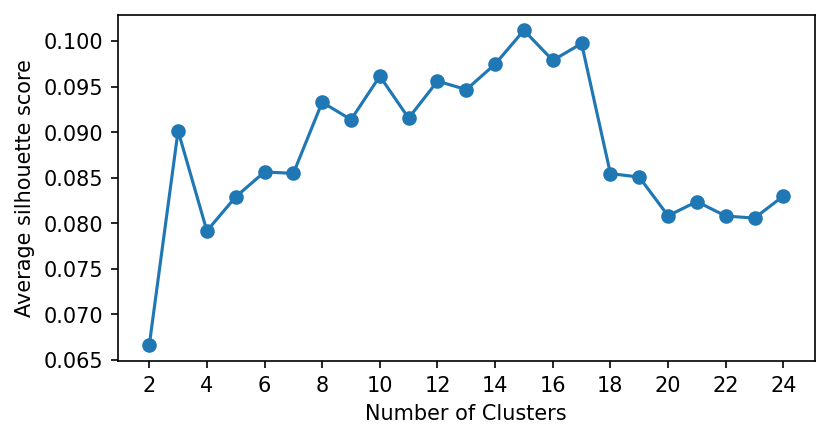

The suggested number of clusters is 15


In [5]:
cluster_validation = validateClusters(counts_matrix, distanceMetric='jensenshannon', clusterMethod='ward', method='silhouette')
fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
ax.plot(cluster_validation[0], cluster_validation[1], '-o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Average {0} score".format(cluster_validation[2]))


fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_SilhouetteValidation_SpeciesLevel.png')
fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_SilhouetteValidation_SpeciesLevel.svg')
plt.show()
print("The suggested number of clusters is {0}".format(cluster_validation[0][np.argmax(cluster_validation[1])]))

## Perform hierarhical clustering to find the number of clusters


In [6]:
CST_Clustering = cluster16SMatrix(counts_matrix, nClusters=15, distanceMetric='jensenshannon', clusterMethod='ward')

### Heatmap plot with the clustering dendrogram

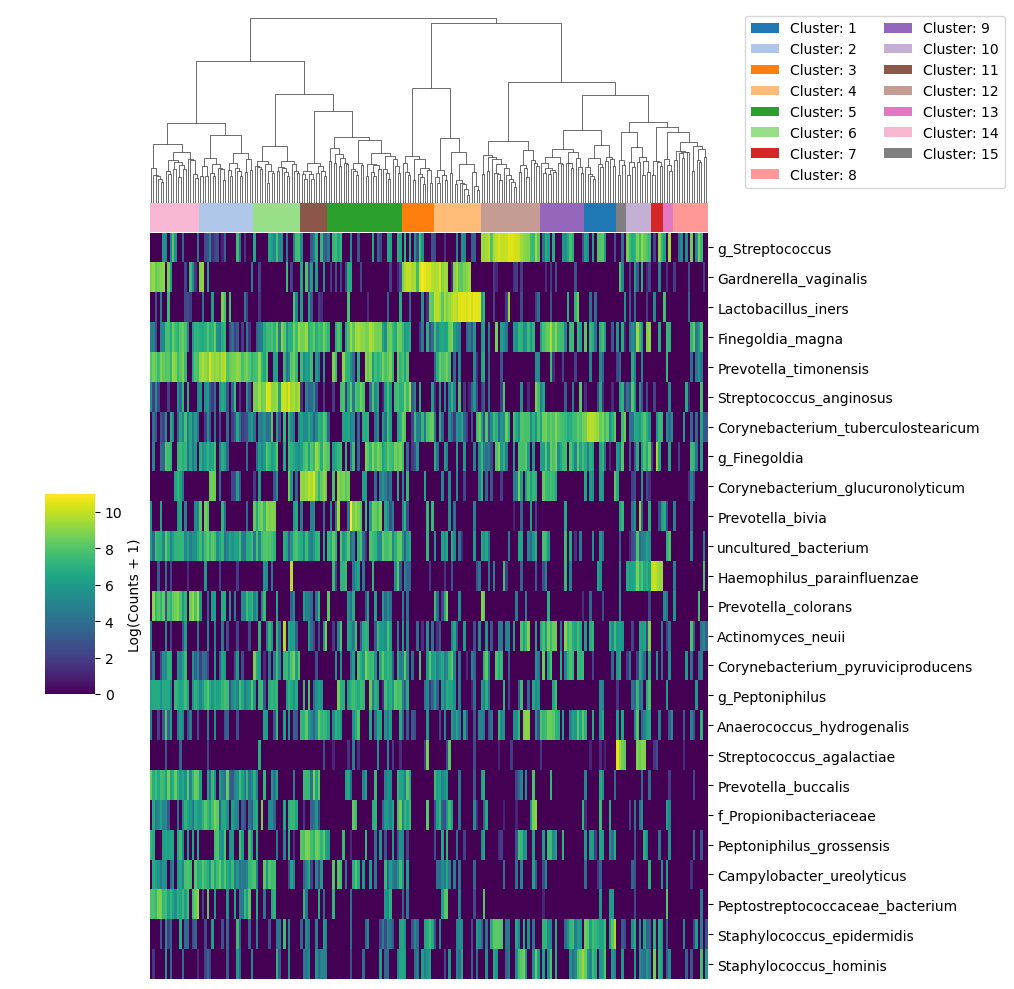

In [7]:
nCST = len(CST_Clustering['clusterID'].unique())

cmap = ListedColormap(sns.color_palette("tab20", nCST))
row_colors = CST_Clustering['clusterID'].map(cmap)

cstMap = sns.clustermap(np.log(counts_matrix.values[:, 0:25].T + 1), col_linkage=CST_Clustering['LinkageMatrix'], 
                        row_cluster=False, col_colors=row_colors.values, yticklabels=counts_matrix.columns[0:25], cmap='viridis', xticklabels=False)

# Add legend with cluster assignments to match the relative abundance plots for interpretation (Genera + Species)
for labelIdx in range(nCST):
    cstMap.ax_col_dendrogram.bar(0, 20, color=cmap(labelIdx), label='Cluster: ' + str(labelIdx + 1), linewidth=0)


cstMap.ax_col_dendrogram.legend(bbox_to_anchor=(1.3, 1), loc='upper center', ncol=2)


# Increase fontsize
cstMap.cax.set_position([0.05, .3, 0.05, .2])
cstMap.cax.set_ylabel('Log(Counts + 1)')

cstMap.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_Species.png', dpi=300)
cstMap.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_Species.svg', dpi=300)

plt.show()


To inspect the characteristic microbial composition of each cluster, we plot the mean relative abundances of the top 6 species per CST cluster.

In [8]:
fig, ax = plt.subplots(5, 3, dpi=300, figsize=(20,45), sharey=True)


for idx, cst in enumerate(CST_Clustering['ClusterAbundances']):
    
    sns.barplot(x=np.arange(0, 6), y=cst[1][0:6], **{'yerr':cst[2][0:6], 'error_kw':{'lolims':True}}, ax=ax[int(np.floor(idx / 3)), idx % 3])
    ax[int(np.floor(idx / 3)), idx % 3].set_xticklabels(cst[1][0:6].index, rotation='vertical', fontsize=15)
    ax[int(np.floor(idx / 3)), idx % 3].tick_params('y', labelsize=15)
    ax[int(np.floor(idx / 3)), idx % 3].set_title("Cluster Number: {0}".format(str(cst[0] + 1)), fontsize=20)
    
ax[0, 0].set_ylabel('Relative abundance (%)', fontsize=15)
ax[1, 0].set_ylabel('Relative abundance (%)', fontsize=15)
ax[2, 0].set_ylabel('Relative abundance (%)', fontsize=15)
ax[3, 0].set_ylabel('Relative abundance (%)', fontsize=15)
ax[4, 0].set_ylabel('Relative abundance (%)', fontsize=15)

fig.tight_layout()
fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_SpeciesDescription.png')
fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_SpeciesDescription.svg')

### Assess the silhouette values for samples accross the CST clusters

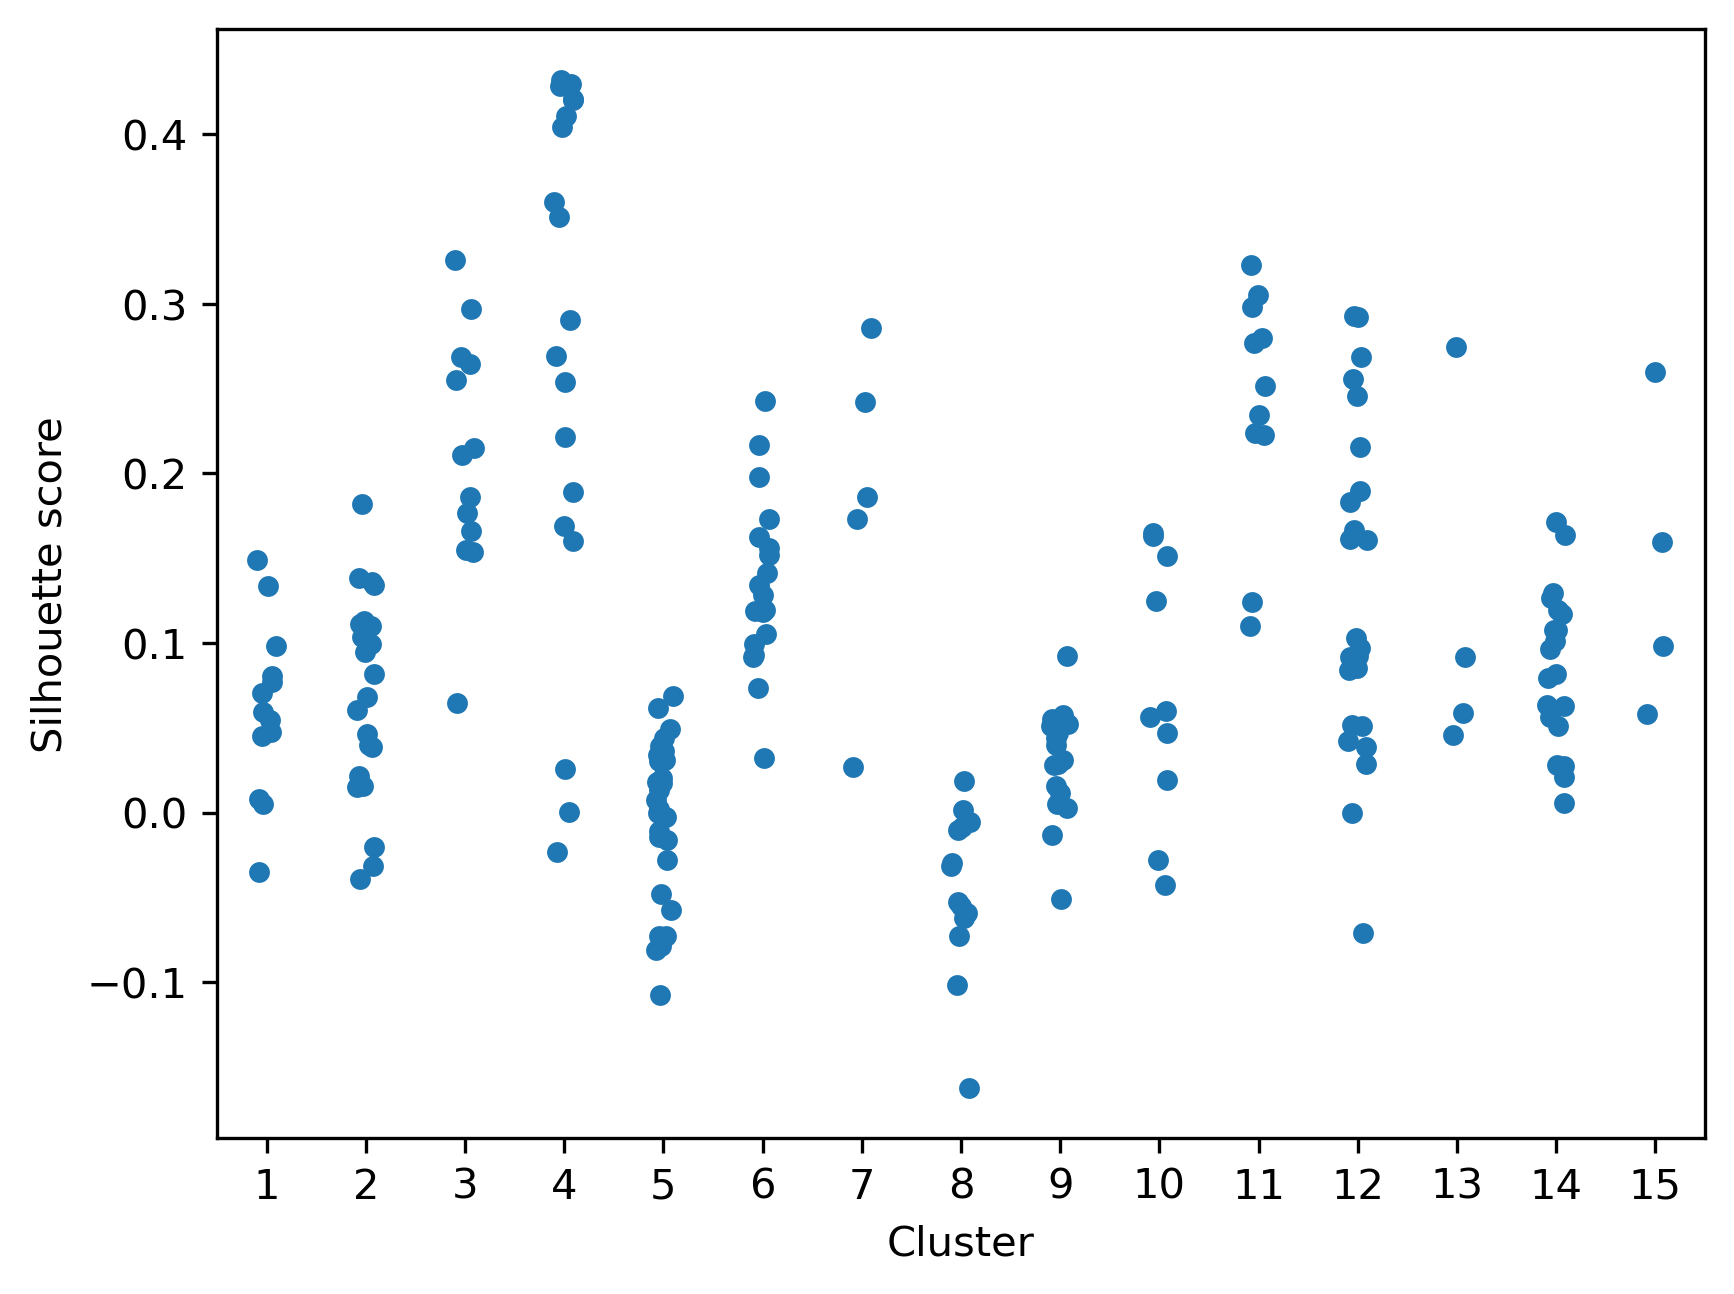

In [9]:
silhFrame = pds.DataFrame({'Cluster':CST_Clustering['clusterID'], 'Silhouette':CST_Clustering['SilhouetteSamples']})
silhFrame['Cluster'] = silhFrame['Cluster']+1 
fig, ax = plt.subplots(dpi=300)
sns.stripplot(data=silhFrame, x='Cluster', y='Silhouette', ax=ax)
ax.set_ylabel('Silhouette score')

fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_SilhouetteSamples_Species.png')
fig.savefig('../Analysis Figures/CSTAnalysis/Semen_16S_CSTClustering_SilhouetteSamples_Species.svg')

## Export the CST Assignments


After obtaining the Community State Type information with hierarchical clustering, we export a dataframe containing the results 

In [10]:
CSTAssignments = pds.DataFrame({'CST':CST_Clustering['clusterID'] + 1,
                                'SilhouetteValues':CST_Clustering['SilhouetteSamples']})

CSTAssignments.index = counts_matrix.index

In [ ]:
os.makedirs('../Results/CST_Analysis', exist_ok=True)
CSTAssignments.to_csv('../Results/CST_Analysis/Semen_CST_SpeciesAssignments.csv')